Bayesian filtering in the frequency domain
---------------------------------------------------

This notebook contains an exploration of the characteristic function as a way to represent a probability distribution, yielding an efficient implementation of a Bayes filter.

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [19]:
from __future__ import print_function, division

import thinkstats2
import thinkplot

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

%matplotlib inline

Suppose you are tracking a rotating part and want to estimate its angle, in degrees, as a function of time, given noisy measurements of its position and velocity.

I'll represent possible positions using a vector of 360 values in degrees.

In [20]:
n = 360
xs = np.arange(n)

I'll represent distributions using a Numpy array of probabilities.  The following function takes a Numpy array and normalizes it so the probabilities add to 1.

In [21]:
def normalize(dist):
    dist /= sum(dist)

The following function creates a discrete approximation of a Gaussian distribution with the given parameters, evaluated at the given positions, `xs`:

In [22]:
def gaussian(xs, mu, sigma):
    dist = stats.norm.pdf(xs, loc=180, scale=sigma)
    dist = np.roll(dist, mu-180)
    normalize(dist)
    return dist

Suppose that initially we believe that the position of the part is 180 degrees, with uncertainty represented by a Gaussian distribution with $\sigma=4$.

Here's what that looks like:

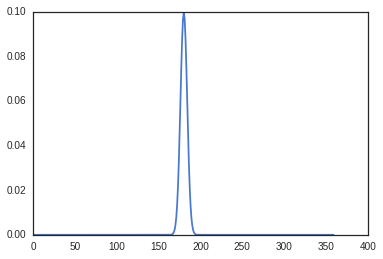

In [23]:
pos = gaussian(xs, mu=180, sigma=4)
plt.plot(xs, pos);

And suppose that we believe the part is rotating at an angular velocity of 15 degrees per time unit, with uncertainty represented by a Gaussian distribution with $\sigma=3$:

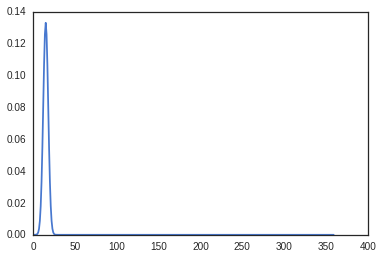

In [24]:
move = gaussian(xs, mu=15, sigma=3)
plt.plot(xs, move);

###The predict step

What should we believe about the position of the part after one time unit has elapsed?

A simple way to estimate the answer is to draw samples from the distributions of position and velocity, and add them together.

The following function draws a sample from a distribution (again, represented by a Numpy array of probabilities).  I'm using a Pandas series because it provides a function that computes weighted samples.

In [25]:
def sample_dist(xs, dist, n=1000):
    series = pd.Series(xs)
    return series.sample(n=n, weights=dist, replace=True).values

As a quick check, the sample from the position distribution has the mean and standard deviation we expect.

In [26]:
pos_sample = sample_dist(xs, pos)
pos_sample.mean(), pos_sample.std()

(179.989, 3.9825719076998474)

And so does the sample from the distribution of velocities:

In [27]:
move_sample = sample_dist(xs, move)
move_sample.mean(), move_sample.std()

(14.922000000000001, 3.1240864264613424)

When we add them together, we get a sample from the distribution of positions after one time unit.

The mean is the sum of the means, and the standard deviation is the hypoteneuse of a triangle with the other two standard deviations.  In this case, it's a 3-4-5 triangle:

In [28]:
sample = pos_sample + move_sample
sample.mean(), sample.std()

(194.911, 5.0055048696410243)

Based on the samples, we can estimate the distribution of the sum.

To compute the distribution of the sum exactly, we can iterate through all possible values from both distributions, computing the sum of each pair and the product of their probabilities:

In [29]:
def add_dist(xs, dist1, dist2):
    res = np.zeros_like(dist1)
    for x1, p1 in zip(xs, dist1):
        for x2, p2 in zip(xs, dist2):
            x = (x1 + x2) % 360
            res[x] = res[x] + p1 * p2
    return res

This algorithm is slow (taking time proportional to $N^2$, where $N$ is the length of `xs`), but it works:

In [30]:
new_pos = add_dist(xs, pos, move)

Here's what the result looks like:

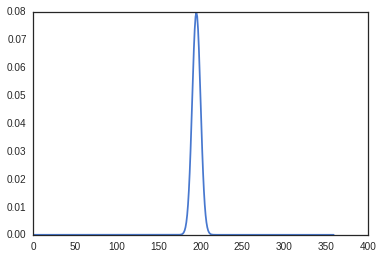

In [31]:
plt.plot(xs, new_pos);

And we can check the mean and standard deviation:

In [32]:
def mean_dist(xs, dist):
    return sum(xs * dist)

The mean of the sum is the sum of the means:

In [33]:
mu = mean_dist(xs, new_pos)
mu

195.00000000000006

And the standard deviation of the sum is the hypoteneuse of the standard deviations:

In [34]:
def std_dist(xs, dist, mu):
    return np.sqrt(sum((xs - mu)**2 * dist))

Which should be 5:

In [35]:
sigma = std_dist(xs, new_pos, mu)
sigma

5.0

What we just computed is the convolution of the two distributions.

Now we get to the fun part.  The characteristic function is an alternative way to represent a distribution.  It is the Fourier transform of the probability density function, or for discrete distributions, the DFT of the probability mass function.

I'll use Numpy's implementation of FFT.  The result is an array of complex, so I'll just plot the magnitude and ignore the phase.

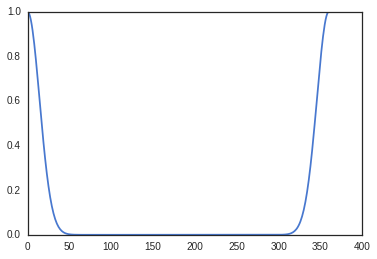

In [36]:
from numpy.fft import fft

char_pos = fft(pos)
plt.plot(xs, np.abs(char_pos));

The Fourier transform of a Gaussian is also a Gaussian, which we can see more clearly if we rotate the characteristic function before plotting it.

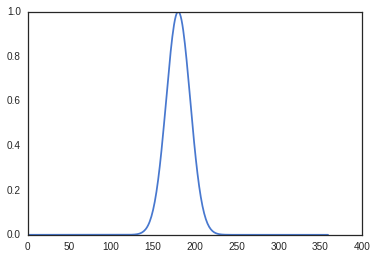

In [37]:
plt.plot(xs, np.roll(np.abs(char_pos), 180));

We can also compute the characteristic function of the velocity distribution:

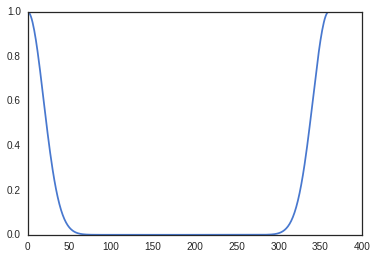

In [38]:
char_move = fft(move)
plt.plot(xs, abs(char_move));

You might notice that the narrower (more certain) the distribution is in the space domain, the wider (less certain) it is in the frequency domain.  As it turns out, the product of the two standard deviations is constant.

We can see that more clearly by plotting the distribution side-by-side in the space and frequency domains:

In [39]:
def plot_dist_and_char(dist):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
    ax1.plot(xs, dist)
    ax1.set_xlabel('space domain')
    char = fft(dist)
    ax2.plot(xs, np.roll(abs(char), 180))
    ax2.set_xlabel('frequency domain')

The following function plots Gaussian distributions with given parameters.

In [40]:
def plot_gaussian_dist_and_char(mu=180, sigma=3):
    dist = gaussian(xs, mu, sigma)
    plot_dist_and_char(dist)

Here's a simple example:

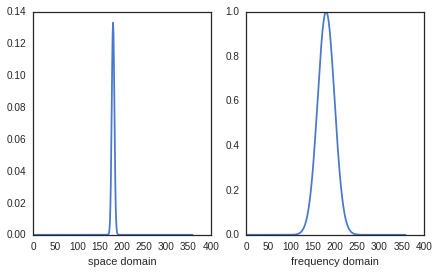

In [41]:
plot_gaussian_dist_and_char(mu=180, sigma=3)

Now we can make sliders to control `mu` and `sigma`.

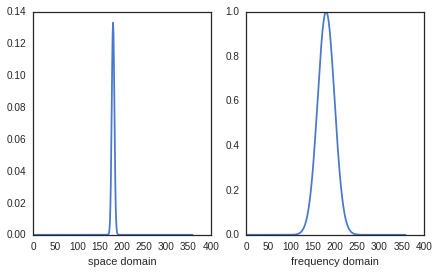

In [42]:
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

slider1 = widgets.IntSliderWidget(min=0, max=360, value=180)
slider2 = widgets.FloatSliderWidget(min=0, max=100, value=3)
interact(plot_gaussian_dist_and_char, mu=slider1, sigma=slider2);

As you increase `sigma`, the distribution gets wider in the space domain and narrower in the frequency domain.

As you vary `mu`, the location changes in the space domain, and the phase changes in the frequency domain, but the magnitudes are unchanged.

But enough of that; I still haven't explained why characteristic functions are useful.  Here it is: If the characteristic function of X is $\phi_X$ and the characteristic function of Y is $\phi_Y$, the characteristic function of the sum X+Y is the elementwise product of $\phi_X$ and $\phi_Y$.

So the characteristic function of the new position (after one time step) is the product of the two characteristic functions we just computed:

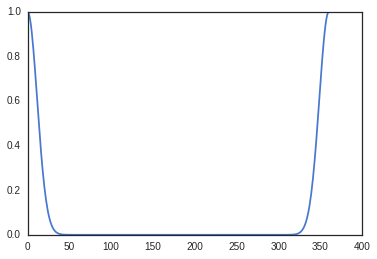

In [43]:
char_new_pos = char_pos * char_move
plt.plot(xs, abs(char_new_pos));

If we compute the inverse FFT of the characteristic function, we get the PMF of the new position:

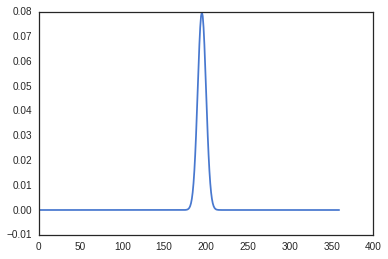

In [44]:
from numpy.fft import ifft

new_pos = ifft(char_new_pos).real
plt.plot(xs, new_pos);

We can check the mean and standard deviation of the result:

In [45]:
def mean_std_dist(xs, dist):
    xbar = mean_dist(xs, dist)
    s = std_dist(xs, dist, xbar)
    return xbar, s

Yup, that's what we expected (forgiving some floating-point errors):

In [46]:
mean_std_dist(xs, new_pos)

(195.00000000000006, 4.9999999999995675)

We can encapsulate this process in a function that computes the convolution of two distributions:

In [47]:
def fft_convolve(dist1, dist2):
    prod = fft(dist1) * fft(dist2)
    dist = ifft(prod).real
    return dist

Since FFT is $N \log N$, and elementwise multiplication is linear, the whole function is $N \log N$, which is better than the $N^2$ algorithm we started with.

The results from the function are the same:

In [48]:
new_pos = fft_convolve(pos, move)
mean_std_dist(xs, new_pos)

(195.00000000000006, 4.9999999999995675)

###The update step

Now suppose that after the move we measure the position of the rotating part with a noisy instrument.  If the measurement is 197 and the standard deviation of measurement error is 4, the following distribution shows the likelihood of the observed measurement for each possible, actual, position of the part:

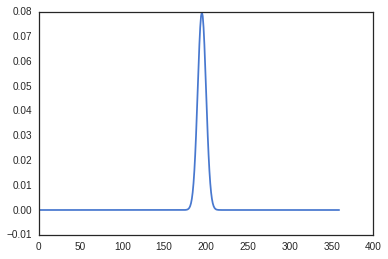

In [49]:
likelihood = gaussian(xs, mu=197, sigma=4)
plt.plot(xs, new_pos);

Now we can take our belief about the position of the part and update it using the observed measurement.  By Bayes's theorem, we compute the product of the prior distribution and the likelihood, then renormalize to get the posterior distribution:

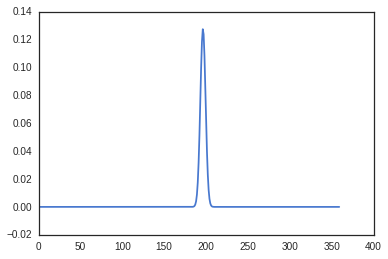

In [50]:
new_pos = new_pos * likelihood
normalize(new_pos)
plt.plot(xs, new_pos);

The prior mean was 195 and the measurement was 197, so the posterior mean is in between, at 196.2 (closer to the measurement because the measurement error is 4 and the standard deviation of the prior is 5).

The posterior standard deviation is 3.1, so the measurement decreased our uncertainty about the location.

In [51]:
mean_std_dist(xs, new_pos)

(196.21951219512201, 3.123475237772122)

We can encapsulate the prediction step in a function:

In [52]:
def predict(xs, pos, move):
    new_pos = fft_convolve(pos, move)
    return new_pos

And likewise the update function:

In [53]:
def update(xs, pos, likelihood):
    new_pos = pos * likelihood
    normalize(new_pos)
    return new_pos

The following function takes a prior distribution, velocity, and a measurement, and performs one predict-update step.

(The uncertainty of the velocity and measurement are hard-coded in this function, but could be parameters.)

In [54]:
def predict_update(xs, pos1, velocity, measure):
    # predict
    move = gaussian(xs, velocity, 3)
    pos2 = predict(xs, pos1, move)
    
    #update
    likelihood = gaussian(xs, measure, 4)
    pos3 = update(xs, pos2, likelihood)
    
    #plot
    plt.plot(xs, pos1, label='pos1')
    plt.plot(xs, pos2, label='pos2')
    plt.plot(xs, pos3, label='pos3')
    plt.legend()
    
    return pos3

In the figure below, `pos1` is the initial belief about the position, `pos2` is the belief after the predict step, and `pos3` is the posterior belief after the measurement.

The taller the distribution, the narrower it is, indicating more certainty about position.  In general, the predict step makes us less certain, and the update makes us more certain.

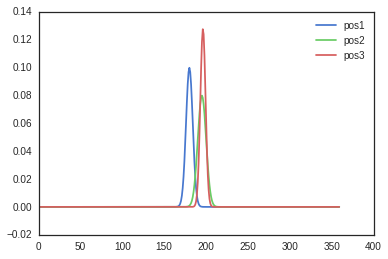

In [55]:
pos1 = gaussian(xs, 180, 4)
pos3 = predict_update(xs, pos1, velocity=15, measure=197)

So far I've been using Gaussian distributions for everything, but in that case we could skip all the computation and get the results analytically.

The implementation I showed generalizes to arbitrary distribitions.  For example, suppose our initial beliefs are multimodal, for example, if we can't tell whether the part has been rotated 90 degrees.

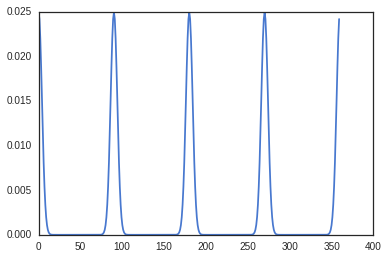

In [56]:
pos1 = (gaussian(xs, 0, 4) + gaussian(xs, 90, 4) + 
        gaussian(xs, 180, 4) + gaussian(xs, 270, 4))
normalize(pos1)
plt.plot(xs, pos1);

Now we can do the same predict-update step:

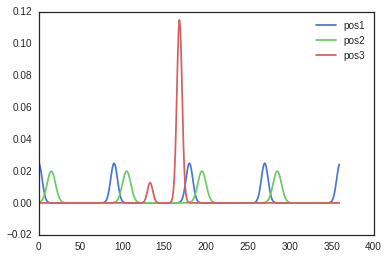

In [57]:
pos3 = predict_update(xs, pos1, velocity=15, measure=151)

After the predict step, our belief is still multimodal.

Then I chose a measurement, 151, that's halfway between two modes.  The result is bimodal (with the other two modes practically eliminated).

If we perform one more step:

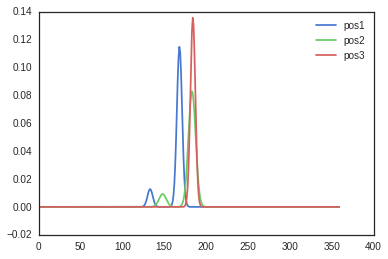

In [58]:
pos5 = predict_update(xs, pos3, velocity=15, measure=185)

Now the posterior is unimodal again (and very close to Gaussian).  In general, if the likelihood function is Gaussian, the result will converge to Gaussian over time, regardless of the initial distribution.